In [18]:
import forecast as fc
import utils as ut
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

## Input parameters
scale = 0.1     #scale for which original is perturbed
n_rnd_param = 2 #number of perturbed matrices to generate
x0 = np.transpose(np.matrix([[0.3,0.4,0.7]]))  #starting point (value from which forecast are made)
horizon = 4    #how many steps-ahead the forecast are made
n_samples = 1000  #how many forecast/trajectories are generated for EACH sampled VAR parameter

## Real values to estimate (array)
A = np.array([[.5,0,0],[.1,.1,.3],[0,.2,.3]]) #A = A1, VAR(p=1)
U = np.array([[2,0.11,0.09],[0.11,1.5,0.13],[0.09,0.13,1]])
print(U)
print(np.linalg.eigvals(A))
print(np.linalg.eigvals(U))

## Generate perturbed matrices
A_noise = fc.pert_matrix(A,scale,n_rnd_param)
U_noise = fc.pert_matrix(U,scale,n_rnd_param)

## Power curve
data_csv = pd.read_csv('data_power.csv') # Speed-PowerGeneration data.
xdata = data_csv['Wind speed (m/s)'].values
ydata = data_csv['Power (kW)'].values
fit_out = curve_fit(ut.PL5, xdata, ydata, maxfev=10000)
a = fit_out[0][0]
b = fit_out[0][1]
c = fit_out[0][2]
d = fit_out[0][3]
g = fit_out[0][4]

[[2.   0.11 0.09]
 [0.11 1.5  0.13]
 [0.09 0.13 1.  ]]
[ 0.46457513 -0.06457513  0.5       ]
[2.03611991 1.49939394 0.96448615]


C:\Users\Samuel\Desktop\2018_01\IIC 3695 Intel Maquina\Tareas y Proyecto\Proyecto\Code\TAIM\utils.py:413: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(np.zeros(Kv),CovU,size=n_samples)


Example figures for first horizon
Resulting mean and quantiles
[array([3.69603324, 3.54490641, 3.5003855 , 3.46116627]), array([2.61394189, 2.3329494 , 2.25427718, 2.16513782]), array([4.90020586, 4.85598179, 4.85163841, 4.75448874])]


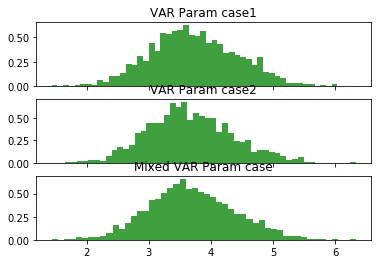

In [19]:
## Simulation of wind speed
cap_wind = 3 # wind plant capacity (eg. 3MW)
cut_speed = 20 # Speed where generator stop working for security.
offset_0 = np.array([3,7,10])
offset_1 = offset_0[:,None,None] #(3,) -> (3,1,1)
ql = 5
qu = 95


sampl_traj = fc.simulate_traj(A_noise,U_noise,x0,offset_1,n_samples,horizon,n_rnd_param,cap_wind,cut_speed, a, b, c, d, g)
list_mix = fc.process_traj(sampl_traj,ql,qu,n_samples,n_rnd_param,horizon,True)

print("Resulting mean and quantiles")
print(list_mix)    

C:\Users\Samuel\Desktop\2018_01\IIC 3695 Intel Maquina\Tareas y Proyecto\Proyecto\Code\TAIM\utils.py:413: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(np.zeros(Kv),CovU,size=n_samples)


Only 1 step ahead forecasts are shown


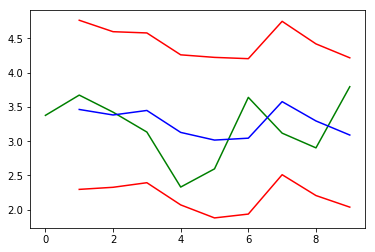

In [39]:
## Ficticious data parameters
n_data = 10 #number of hours in which forecasts are made (different from horizon)
#x_data = np.random.rand(3,n_data) + offset_0[:,None] #rnd matrix with numbers between [0,1)
K_dim  = A.shape[0]

## Generate ficticious data from which sample (x_data is zero mean)
x_data = np.zeros((3,n_data)) #it is assummed previous value was zero
for t in range(1,n_data):
    x0_aux = x_data[:,t-1]
    fc_wind = ut.sim_wind(A,U,x0_aux[:,None],1,1)
    x_data[:,t] = fc_wind.flatten() 

## 'Real' total generation from data
wind_data = x_data + offset_0[:,None]# here offset is added so real total generation is consistent
pow_data = ut.power_curve(wind_data,cap_wind,cut_speed,a,b,c,d,g) #apply power curve
gen_data = np.sum(pow_data,axis=0) #sum for all wind farms

## Forecasts
mean_t = np.zeros((n_data,horizon)) #mean
ql_t = np.zeros((n_data,horizon)) #lower quantile
qu_t = np.zeros((n_data,horizon)) #upper quantile

for t in range(n_data):
    #get previous point from which forecast is made
    x0 = x_data[:,t]
    x0 = x0[:,None]
    
    #make forecast
    sampl_traj = fc.simulate_traj(A_noise,U_noise,x0,offset_1,n_samples,horizon,n_rnd_param,cap_wind,cut_speed, a, b, c, d, g)
    list_mix = fc.process_traj(sampl_traj,ql,qu,n_samples,n_rnd_param,horizon,False)
    mean_t[t,:] = list_mix[0]
    ql_t[t,:] = list_mix[1]
    qu_t[t,:] = list_mix[2]
    
print("Only 1 step ahead forecasts are shown")
plt.figure()
plt.plot(range(n_data),gen_data,color='green') #'real' generation'
plt.plot(range(1,n_data),mean_t[:-1,0],color='blue') #mean forecast
plt.plot(range(1,n_data),ql_t[:-1,0],color='red') #interval forecast
plt.plot(range(1,n_data),qu_t[:-1,0],color='red') 
plt.show()